In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
import warnings
from defs import regularAtlmask

In [2]:
datafolder = ''

In [3]:
experiment = 'E280' 
model = 'HadGEM3'
folder = datafolder+'Raw_data/'+model+'/'

In [7]:
dsV = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Raw_data/'+model+'/'+experiment+'/vo_100yr.nc')
dsS = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Raw_data/'+model+'/'+experiment+'/so_100yr.nc')
dsT = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Raw_data/'+model+'/'+experiment+'/thetao_100yr.nc')
dsr = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Raw_data/'+model+'/'+experiment+'/subbasins_CMIP6.nc')

if experiment == 'E280':
    dsOHT = xr.open_dataset(folder+experiment+'/clims_hadgem3_pi_totaloceanheat.nc',decode_times=False)
    dsice = xr.open_dataset(folder+experiment+'/clims_hadgem3_pi_fraccice_final.nc',decode_times=False)

else:
    dsOHT = xr.open_dataset(folder+experiment+'/clims_hadgem3_pliocene_oht_final.nc',decode_times=False)
    dsice = xr.open_dataset(folder+experiment+'/clims_hadgem3_pliocene_fraccice_final.nc',decode_times=False)


## Separation MOC and gyre OHT component 100-yr average

In [8]:
dsV = dsV.rename({'nav_lon': 'ULONG', 'nav_lat': 'ULAT', 'depthv': 'olevel'})
dsT = dsT.rename({'nav_lon': 'TLONG', 'nav_lat': 'TLAT', 'deptht': 'olevel'})
dsS = dsS.rename({'nav_lon': 'TLONG', 'nav_lat': 'TLAT', 'deptht': 'olevel'})
dsr = dsr.rename({'nav_lon': 'TLONG', 'nav_lat': 'TLAT'})

In [9]:
temp = dsT.thetao
region = dsr.atlmsk

#Regrid velocity to temperature grid (fill NaN with zero values first to avoid NaN in interpolated ocean grid cells)
regridder = xe.Regridder(dsV, dsT, 'bilinear', periodic = True, ignore_degenerate=True)
vo = dsV.vo.fillna(0)*100
vvel = regridder(vo) #cm/s
vvel = vvel*temp/temp #Fill land values with NaN again

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Create DXT grid

In [10]:
dphi = np.zeros([332,362])
lat = dsT.TLAT.values
dphi[:,1:] = lat[:,1:]-lat[:,:-1]
dphi[:,0] = lat[:,0]-lat[:,-1]
dphi = np.radians(dphi)

dtheta = np.zeros([332,362])
lon = dsT.TLONG.values
dtheta[:,1:] = lon[:,1:]-lon[:,:-1]
dtheta[:,0] = lon[:,0]-lon[:,-1]

for j in range(332):
    for i in range(200,300):
        if dtheta[j,i] < -300:
            dtheta[j,i] = dtheta[j,i]+360
dtheta = np.radians(dtheta)

phi1 = np.zeros([332,362])
phi1[:,0] = lat[:,-1]
phi1[:,1:] = lat[:,:-1]
phi1 = np.radians(phi1)

phi2 = np.radians(lat)

r = 6.37122e8 #radius Earth in cm
d = 2*r*np.arcsin(np.sqrt(np.sin(dphi/2)**2+np.cos(phi1)*np.cos(phi2)*np.sin(dtheta/2)**2)) #Distance between adjacent cells in i dimension on U grid [cm]
dsT['d'] = xr.DataArray(data=d, dims=("j","i")) 
DXT = np.zeros([332,362])
DXT[:,:-1] = (d[:,1:]+d[:,:-1])/2
DXT[:,-1] = (d[:,0]+d[:,-1])/2

dsT['DXT'] = xr.DataArray(data=DXT, dims=("y","x")) #Grid lengths centered on T-points [cm]

Create DZ array

In [11]:
#1-D array with spacing of depth grid
ds = dsT.copy(deep=True)

dz = np.zeros(len(ds.olevel))
dz[0] = ds.olevel[0].values*2
depth = dz[0]
for i in range(1,len(ds.olevel)):
    dz[i] = (ds.olevel[i]-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
dsV['DZ'] = xr.DataArray(data=dz, dims=("olevel"))
dsT['DZ'] = xr.DataArray(data=dz, dims=("olevel"))
DZ = dsT.DZ

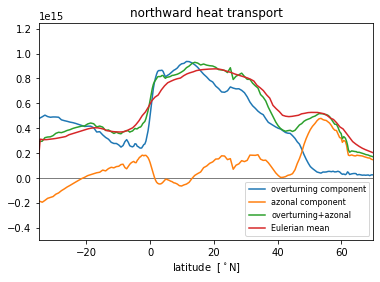

In [12]:
cp_sw = 3996.  # [J/(kg degC)]   heat capacity of water
rho_sw = 1.026e-3  # [kg/cm^3]  density of water

VVEL = vvel.where(region>0) #cm/s
HEAT = (cp_sw*rho_sw*temp).where(region>0)  #  [J/(kg K) * kg/cm^3 * degC] = [J/cm]

def zonal_means(x, dx):
    xint = (x*dx).sum('x')  # [x-unit * cm]
    zm = xint/dx.sum('x')   # [x-unit]
    return xint, zm

#Zonal mean velocity and heat
VVEL_xint, VVEL_zm = zonal_means(VVEL, dsT.DXT.where(VVEL<10000))
HEAT_xint, HEAT_zm = zonal_means(HEAT, dsT.DXT.where(VVEL<10000))

#Make zonal mean fields into 3D fields again
HEAT_zm_3D = HEAT/HEAT
HEAT_zm_3D = HEAT_zm_3D*HEAT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components
HEAT_prime = (HEAT - HEAT_zm) # azonal heat component (x,y,z) [J/cm]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

#Integrate to compute OHTov and OHTaz
Hov = (VVEL_zm_3D*HEAT_zm_3D*dsT.DXT*dsT.DZ).sum(dim=['x','olevel'])
Haz = (VVEL_prime*HEAT_prime*dsT.DXT*dsT.DZ).sum(dim=['x','olevel'])  # product of primed velocity and heat [cm/s * J/cm^2 * cm]

#Auxiliary latitudes for OHtov and OHTaz
lats = dsT.TLAT.where(region>0).mean(dim='x')

plt.figure(figsize=(6,4))
plt.axhline(0,c='k',lw=.5)
plt.plot(lats, Hov, label='overturning component')

plt.plot(lats, Haz, label='azonal component')
plt.plot(lats, (Hov+Haz), label='overturning+azonal')
plt.plot(dsOHT.latitude, dsOHT.OHT_atlantic.mean(dim='time')[:,0]*1e15,label='Eulerian mean')
plt.title('northward heat transport')
plt.xlim([-35,70])
plt.ylim([-0.5e15, 1.25e15])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [13]:
dsE = xr.Dataset(data_vars = dict(OHTov=(["lat"], Hov[134:-2]/1e15), OHTaz=(["lat"], Haz[134:-2]/1e15)), coords = dict(lat = lats[134:-2].values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'/Processed/'+model+'/'+experiment+'/decomOHT_100yr.nc')

## 100-yr mean and annual time series AMOC streamfunction

In [14]:
warnings.filterwarnings(action='ignore', message='Mean of empty slice')

#Open files: one file for every year
folder = datafolder+'Raw_data/HadGEM3/'+experiment+'/Timeseries_OHT_MOC/'
filename_data= '*.nc'
files = glob.glob(folder+filename_data)
files.sort()

#Combine into a single file and make any cells with value zero into NaN
amoc = np.zeros([100,75,180])
for i in range(100):
    amoc_monthly = np.zeros([12,75,180])
    for j in range(12):
        ds = xr.open_dataset(files[i*12+j])
        a = ds.zomsfatl[0,:,:,0].where(ds.zomsfatl[0,:,:,0]!=0)
        amoc_monthly[j,:,:] = a.values
    amoc[i,:,:]=np.nanmean(amoc_monthly, axis=0)

if experiment =='E280':
    dsM2 = xr.Dataset(data_vars = dict(AMOC=(("time","z","lat"), amoc)), coords = dict(time = np.arange(1950, 2050), z = ds.depthw.values, lat = ds.lat.values))
else:
    dsM2 = xr.Dataset(data_vars = dict(AMOC=(("time","z","lat"), amoc)), coords = dict(time = np.arange(2334, 2434), z = ds.depthw.values, lat = ds.lat.values))
    
dsM = xr.Dataset(data_vars = dict(AMOC=(("z","lat"), np.nanmean(amoc, axis=0))), coords = dict(z = ds.depthw.values, lat = ds.lat.values))

xr.Dataset.to_netcdf(dsM2, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_annual_100yr.nc')
xr.Dataset.to_netcdf(dsM, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_100yr.nc')

## 100-yr mean total Atlantic OHT

In [15]:
#Open files: one file for every year
folder = datafolder+'Raw_data/HadGEM3/'+experiment+'/Timeseries_OHT_MOC/'
filename_data= '*.nc'
files = glob.glob(folder+filename_data)
files.sort()

#Combine into one file
oht = np.zeros([1200,180])
for i in range(1200):
    ds = xr.open_dataset(files[i])
    oht[i,:] = ds.hfbasin_atlantic[0,:,0].values

#Compute 100-year mean
oht = np.mean(oht, axis=0)

dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), oht)), coords = dict(lat = ds.lat.values))
xr.Dataset.to_netcdf(dsH, path = datafolder+'Processed/'+model+'/'+experiment+'/OHT_100yr.nc')

## Annual SST timeseries (100 years)

In [16]:
dstos = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/thetao_annual_100yr.nc',decode_times=False)
dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)

regridder = xe.Regridder(dstos, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
tos = regridder(dstos.thetao[:,0,:,:])

if experiment =='E280':
    dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tos.values)), coords = dict(time = np.arange(1950, 2050), lat = tos.latitude.values, lon = tos.longitude.values))
else:
    dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tos.values)), coords = dict(time = np.arange(2334, 2434), lat = tos.latitude.values, lon = tos.longitude.values))

xr.Dataset.to_netcdf(dsSST, path = datafolder+'Processed/'+model+'/'+experiment+'/SST_annual_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr SSS (regridded)

In [17]:
dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

sss = regridder(dsS.so[0])

dsSSS = xr.Dataset(data_vars = dict(sss=(("lat","lon"), sss)), coords = dict(lat = sss.latitude.values, lon = sss.longitude.values))
xr.Dataset.to_netcdf(dsSSS, path = datafolder+'Processed/'+model+'/'+experiment+'/SSS_100yr.nc')

## 100-yr sea ice (regridded)

In [18]:
djf = (dsice.seaice[11]+dsice.seaice[0]+dsice.seaice[1])/3
mam = (dsice.seaice[2]+dsice.seaice[3]+dsice.seaice[4])/3
jja = (dsice.seaice[5]+dsice.seaice[6]+dsice.seaice[7])/3
son = (dsice.seaice[8]+dsice.seaice[9]+dsice.seaice[10])/3

dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsice, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

si_djf = regridder(djf)*100
si_mam = regridder(mam)*100
si_jja = regridder(jja)*100
si_son = regridder(son)*100

si = (si_djf+si_mam+si_jja+si_son)/4

dsSI = xr.Dataset(data_vars = dict(si_djf=(("lat","lon"), si_djf), si_mam = (("lat","lon"), si_mam), si_jja = (("lat","lon"), si_jja), si_son = (("lat","lon"), si_son), si_mean = (("lat","lon"), si)), coords = dict(lat = si_djf.latitude.values, lon = si_djf.longitude.values))
xr.Dataset.to_netcdf(dsSI, path = datafolder+'Processed/'+model+'/'+experiment+'/SI_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean top 100 m salinity

In [19]:
def makedz(z):
    dz = np.zeros(len(z))
    dz[0] = z[0].values*2
    depth = dz[0]
    for i in range(1,len(z)):
        dz[i] = (z[i]-depth)*2
        depth = depth+dz[i] #Depth spacing. Units: cm
    return xr.DataArray(data=dz, dims=("olevel"))

regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
weights = makedz(dsS.olevel[0:23])

s100m = regridder(dsS.so[0:23].weighted(weights).mean(dim='olevel'))

dsS100m = xr.Dataset(data_vars = dict(s100m=(("lat","lon"), s100m)), coords = dict(lat = s100m.latitude.values, lon = s100m.longitude.values))
xr.Dataset.to_netcdf(dsS100m, path = datafolder+'Processed/'+model+'/'+experiment+'/so100m_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr zonal mean temperature

In [20]:
temp_atl = dsT.thetao

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsT, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

temp = regridder(temp_atl)
mask = regularAtlmask(temp)

temp_zm = temp.where(mask>-1).mean(dim='longitude')

dtzm = xr.Dataset(data_vars = dict(thetao=(("z","lat"), temp_zm)), coords = dict(z = temp_zm.olevel.values, lat = temp_zm.latitude.values))
xr.Dataset.to_netcdf(dtzm, path = datafolder+'Processed/'+model+'/'+experiment+'/thetao_zm_100yr.nc')

## 100-yr zonal mean salinity

In [21]:
salt_atl = dsS.so

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

salt = regridder(salt_atl)
mask = regularAtlmask(salt)

salt_zm = salt.where(mask>-1).mean(dim='longitude')

dszm = xr.Dataset(data_vars = dict(so=(("z","lat"), salt_zm)), coords = dict(z = salt_zm.olevel.values, lat = salt_zm.latitude.values))
xr.Dataset.to_netcdf(dszm, path = datafolder+'Processed/'+model+'/'+experiment+'/so_zm_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean wind at 1000 hPa

In [22]:
folder = datafolder+'Raw_data/'+model+'/'

if experiment == 'E280':
    dsu = xr.open_dataset(folder+experiment+'/Atm/clims_hadgem3_pi_u_final.nc',decode_times=False)
    dsv = xr.open_dataset(folder+experiment+'/Atm/clims_hadgem3_pi_v_final.nc',decode_times=False)

else:
    dsu = xr.open_dataset(folder+experiment+'/Atm/clims_hadgem3_pliocene_u_final.nc',decode_times=False)
    dsv = xr.open_dataset(folder+experiment+'/Atm/clims_hadgem3_pliocene_v_final.nc',decode_times=False)

In [23]:
ua = dsu.u.mean(dim='time')[0]
va = dsv.v.mean(dim='time')[0]

dsgrid = xr.open_dataset(datafolder+'Raw_data/'+model+'/'+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsu, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

u = regridder(ua)
v = regridder(va)

dsUV = xr.Dataset(data_vars = dict(ua=(("lat","lon"), u), va=(("lat","lon"), v)), coords = dict(lat = u.latitude.values, lon = v.longitude.values))
xr.Dataset.to_netcdf(dsUV, path = datafolder+'Processed/'+model+'/'+experiment+'/UVa_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
